<a href="https://colab.research.google.com/github/ABoldetti/My_first_Repository/blob/main/Labo2/Circuiti3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TODO



*   Cambiare le equazioni nei grafici ✅
*   Fixare gli angoli che non escono
*   Calcolare gli effettivi valori ✅
*   Fare il grafico del critico in funzione della resistenza ✅



In [ ]:
#@title Update data

UPDATE_DATA = "False" #@param['True','False']

# Utilities

In [ ]:
#@title Librerie

try:
  from iminuit import Minuit
  from iminuit.cost import *
except:
  !pip install iminuit
  from iminuit import Minuit
  from iminuit.cost import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sympy import *
from scipy.stats import chi2,skew,kurtosis,norm,cauchy
from IPython.display import Latex
from google.colab import files

In [ ]:
#@title import file

try:
  if UPDATE_DATA:
    print(SHEEESH)
  else:
    ausy = data[0]
except:
  data = 'https://docs.google.com/spreadsheets/d/1TBClD8z-R6a451Wf2QCjsajkYlFjTwsy06t5F8HHkL0/export?format=xlsx'
  df = pd.read_excel(data, sheet_name=None)
  name =list(df.keys())

  data = []
  for i in range(6,len(df.keys())):
    data.append(df[name[i]])

In [ ]:
#@title error prop

def insert( vector ) -> list:
    #Handling edge cases
    if len(vector) == 1:
      vector = symbols( str(vector) )
      sigmas = f"sigma_{vector}"
      covar = None
      all = sigmas
    elif len(vector) == 2:
      string = ' '.join( vector )
      vector = symbols( string )
    #creation of sigmas and covariants
      sigmas = []
      covar = []
      all = []
      for i in range(len(vector)):
        sigmas.append( f"sigma_{vector[i]}" )
        all.append( f"sigma_{vector[i]}" )
      sigmastring = ' '.join( sigmas )
      sigmas = symbols( sigmastring )
      covar.append(f"sigma_{vector[0]}{vector[1]}")
      covarstring = ' '.join( covar )
      covar = symbols( covarstring )
      all.append(covar)
    else:
      string = ' '.join( vector )
      vector = symbols( string )
      #creation of sigmas and covariants
      sigmas = []
      covar = []
      all = []
      for i in range(len(vector)):
        for j in range( i , len(vector)):
          if i == j:
            sigmas.append( f"sigma_{vector[i]}" )
            all.append( f"sigma_{vector[i]}" )
          else:
            covar.append( f"sigma_{vector[i]}{vector[j]}")
            all.append( f"sigma_{vector[i]}{vector[j]}")

      sigmastring = ' '.join( sigmas )
      sigmas = symbols( sigmastring )
      covarstring = ' '.join( covar )
      covar = symbols( covarstring )
    return vector, sigmas , covar, all

def derivazione(variables, formula, sigmas , covar) -> str:
    expo = 0
    # add the sigmas
    for i in range(len(variables)):
      expo += (diff(formula, variables[i]))**2 * sigmas[i]
      # add the covs
    k = 0
    if isinstance( covar , Symbol) :
      expo += 2 * (diff(formula, variables[0])) * (diff(formula, variables[1])) * covar
    else:
      for i in range(len(variables)):
        for j in range(len(variables)-i-1):
          expo += 2 * (diff(formula, variables[i])) * (diff(formula, variables[1+j+i])) * covar[k]
          k += 1
    return expo



def propagazione_errore (vector, formula , values , covmat , var_else = None, val_else = None, Display = True) -> str:

    if isinstance(var_else , list):
      things,a,a,a = insert(var_else)

    variables,sigmas,covar,all = insert(vector)

    expo = derivazione (variables, formula, sigmas , covar)

    if Display: display(Latex('\sigma='+latex(simplify(sqrt(expo)))))

    if len(variables) == 1:
      expo = expo.subs( variables , values)
      expo = expo.subs( sigmas , covmat)
    else:
      for i in range(len(variables)): expo = expo.subs( variables[i] , values[i])
      k = 0
      for i in range(len(covmat)):
        expo = expo.subs( all[k] , covmat[i][i])
        k +=1
      for i in range( len(covmat)):
        for j in range(i+1 , len(covmat[i])):
          expo = expo.subs( all[k] , covmat[i][j])
          k+=1
    if isinstance(var_else , list):
      if len(var_else ) == 1:
        expo = expo.subs( symbols(var_else[0]) , val_else[0])
      else:
        for i in range(len(var_else)): expo = expo.subs( things[i] , val_else[i])
    return sqrt(expo)


# Modelli

In [ ]:
#Circuito RC
#t = RC
def Mod_R_RC( w , t , V):
  return V*t*2*np.pi*w/(np.sqrt(1+np.power(2*np.pi*t*w , 2)))

def Mod_C_RC( w , t , V ):
  return V/(np.sqrt(1+np.power(t*2*np.pi*w , 2)))

def Arg_R_RC( w , t ):
  return np.pi/2 - np.arctan(2*np.pi*w*t)

def Arg_C_RC( w , t):
  return - np.arctan(2*np.pi*w*t)


#Circuito RL
# t = L/R
def Mod_R_RL( w , t , V ):
  return V / np.sqrt( 1 + np.power( t*2*np.pi*w , 2))

def Mod_L_RL( w , t , V ):
  return V*2*np.pi*w / np.sqrt(np.power(1/t,2) + np.power( 2*np.pi*w , 2))

def Arg_R_RL( w , t):
  return np.arctan(2*np.pi*w*t)

def Arg_L_RL( w , t):
  return np.pi * .5- np.arctan(2*np.pi*w*t)

#Circuito RLC
# g = RC
# t = LC

def Mod_R_RLC( w , g , t , V):
  return V*2*np.pi*w*g / np.sqrt( np.power( 1 - np.power( 2*np.pi*w , 2 )*t , 2) + np.power( 2*np.pi*w*g , 2) )

def Mod_L_RLC( w, g , t , V ):
  return V*(np.power( 2*np.pi*w , 2) * t)/(np.sqrt(np.power( g * 2*np.pi*w , 2 ) + np.power( 1 - np.power( 2*np.pi*w , 2) * t , 2 )))

def Mod_C_RLC( w, g , t , V):
  return V/(np.sqrt(np.power( g * 2*np.pi*w , 2 ) + np.power( 1 - np.power( 2*np.pi*w , 2) * t , 2 )))

def Arg_R_RLC( w , L , C):
  R = 1e3
  return np.arctan((w*L - 1/(w*C))/R)

def Arg_L_RLC( w , L , C ):
  R = 1e3
  return np.pi*.5 - np.arctan((w*L - 1/(w*C))/R)

def Arg_C_RLC( w , L , C ):
  R = 1e3
  return -np.pi*.5 - np.arctan((w*L - 1/(w*C))/R)

def prova( w , g , t ):
  return 10*np.pi*w*g / np.sqrt( np.power( 1 - np.power( 2*np.pi*w , 2 )*t , 2) + np.power( 2*np.pi*w*g , 2) )



#Costanti varie ed eventuali
R1 = 15e3
R2 = 1.04e3
R3 = 1.04e3

Ct = 1e-7
Lt = 0.08

Rc = [1040 , 140 , 540 , 2540 , 5040 , 790]



# Circuito RC


## Voltaggio resistenza

In [ ]:
#@title analisi dati
n=0
x1 = np.array(data[n][data[n].columns[0]])
y1 = np.array(data[n][data[n].columns[1]])
sy1 = np.array(data[n][data[n].columns[2]])

print(sy1)


mod_R = LeastSquares(x1,y1,sy1 , Mod_R_RC)
RCmR = Minuit( mod_R , V = 5 , t = 15e3 *1e-7 )

RCmR.migrad()
RCmR.hesse()

display(RCmR)



[0.01292543 0.00864099 0.01182652 0.02041241 0.02081346 0.01468332]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.9395 (χ²/ndof = 0.2)     │              Nfcn = 41               │
│ EDM = 4.04e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ t    │ 1.456e-3  │ 0.012e-3  │            │            │         │         │       │
│ 1 │ V    │   4.954   │   0.013   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │         t         V │
├───┼─────────────────────┤
│ t │  1.53e-10 -85.21e-9 │
│ V │ -85.21e-9   0.00017 │
└───┴─────────────────────┘

In [ ]:
#@title Values



t = RCmR.values[0]

C1 = t/R1
errC1 = propagazione_errore( ['t' , 'R'] , 't/R' , [t,R1] , [[RCmR.errors[0]**2 , 0],[ 0 , .1]])

print(' C = \t' , format(C1 , '.3e') , '+-' , format(errC1, '.3e'))

<IPython.core.display.Latex object>

 C = 	 9.704e-08 +- 8.243e-10


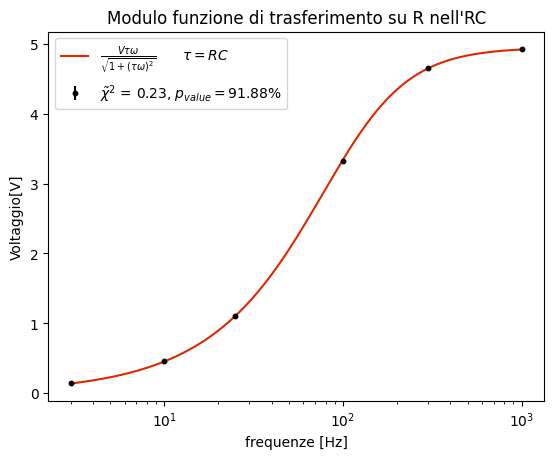

In [ ]:
#@title Graph
a = RCmR
x = x1
y = y1
sy = sy1
txt = 'RCmR.pdf'
f = Mod_R_RC

func = r'$\frac{V \tau \omega}{\sqrt{1+(\tau \omega)^{2}}}$      $\tau = RC$'
plt.xlabel( 'frequenze [Hz]')
plt.ylabel( 'Voltaggio[V]')
plt.title('Modulo funzione di trasferimento su R nell\'RC')

plt.xscale('log')


chi = 1-chi2.cdf(a.fval, df= a.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(a.fval/a.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.errorbar( x , y , sy , fmt='o' , markersize=3.2 , color='#000000', label = chi_string)
plt.plot( np.linspace( min(x) , max(x), 10000) ,f( np.linspace( min(x) , max(x), 10000) , a.values[0] , a.values[1]), color = '#DF2700' , label = func)
plt.legend()


plt.savefig(txt)
plt.show()
#files.download(txt)

In [ ]:
#@title analisi dati
n=2
x3 = np.array(data[n][data[n].columns[0]])
y3 = np.array(data[n][data[n].columns[1]])
sy3 = np.array(data[n][data[n].columns[2]])*2


y3[0] = 90

y3 = y3*(np.pi)/180
sy3 = sy3 * (np.pi)/180

arg_R = LeastSquares(x3,y3,sy3 , Arg_R_RC)
RCaR = Minuit( arg_R , t = 0.0015 )


RCaR.limits['t'] = ( 0 , None)
RCaR.migrad()
RCaR.hesse()

display(RCaR)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.684 (χ²/ndof = 0.3)      │              Nfcn = 21               │
│ EDM = 2.22e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ t    │  1.43e-3  │  0.05e-3  │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        t │
├───┼──────────┤
│ t │ 2.27e-09 │
└───┴──────────┘

In [ ]:
#@title Values

t = RCaR.values[0]

C2 = t/R1
errC2 = propagazione_errore( ['t' , 'R'] , 't/R' , [t,R1] , [[RCaR.errors[0]**2 , 0],[ 0 , .1]])

print(' C = \t' , format(C2 , '.3e') , '+-' , format(errC2, '.3e'))

<IPython.core.display.Latex object>

 C = 	 9.562e-08 +- 3.177e-9


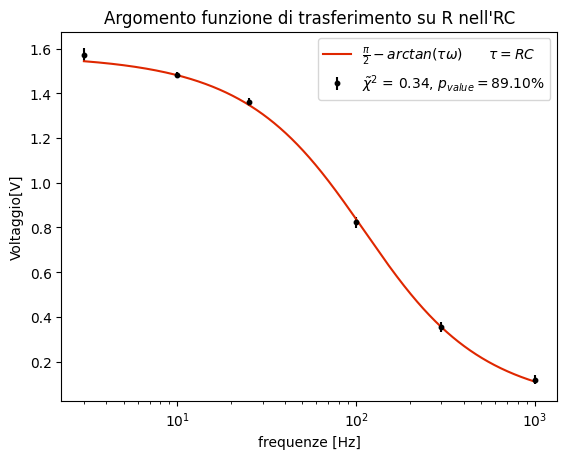

In [ ]:
#@title Graph
a = RCaR
x = x3
y = y3
sy = sy3
txt = 'RCaR.pdf'
f = Arg_R_RC


func = r'$ \frac{\pi}{2} - arctan( \tau \omega)$      $\tau = RC$'
plt.xlabel( 'frequenze [Hz]')
plt.ylabel( 'Voltaggio[V]')
plt.title('Argomento funzione di trasferimento su R nell\'RC')

plt.xscale('log')


chi = 1-chi2.cdf(a.fval, df= a.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(a.fval/a.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.errorbar( x , y , sy , fmt='o' , markersize=3.2 , color='#000000', label = chi_string)
plt.plot( np.linspace( min(x) , max(x), 10000) ,f( np.linspace( min(x) , max(x), 10000) , a.values[0]), color = '#DF2700' , label = func)
plt.legend()


plt.savefig(txt)
plt.show()
#files.download(txt)

## Voltaggio Capacità

In [ ]:
#@title analisi dati
n=1
x2 = np.array(data[n][data[n].columns[0]])
y2 = np.array(data[n][data[n].columns[1]])
sy2 = np.array(data[n][data[n].columns[2]])
y2[0] = 5


mod_C = LeastSquares(x2,y2,sy2 , Mod_C_RC)
RCmC = Minuit( mod_C , t = 15e3 *1e-7 , V=5 )

#RCmC.fixed['t'] = True
RCmC.migrad()
RCmC.hesse()

display(RCmC)



┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.525 (χ²/ndof = 1.9)      │              Nfcn = 44               │
│ EDM = 2.22e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ t    │ 1.411e-3  │ 0.034e-3  │            │            │         │         │       │
│ 1 │ V    │   4.967   │   0.028   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        t        V │
├───┼───────────────────┤
│ t │ 1.15e-09 385.4e-9 │
│ V │ 385.4e-9 0.000794 │
└───┴───────────────────┘

In [ ]:
#@title Values

t = RCmC.values[0]

C3 = t/R1
errC3 = propagazione_errore( ['t' , 'R'] , 't/R' , [t,R1] , [[RCmC.errors[0]**2 , 0],[ 0 , .1]])

print(' C = \t' , format(C3 , '.3e') , '+-' , format(errC3, '.3e'))

<IPython.core.display.Latex object>

 C = 	 9.409e-08 +- 2.260e-9


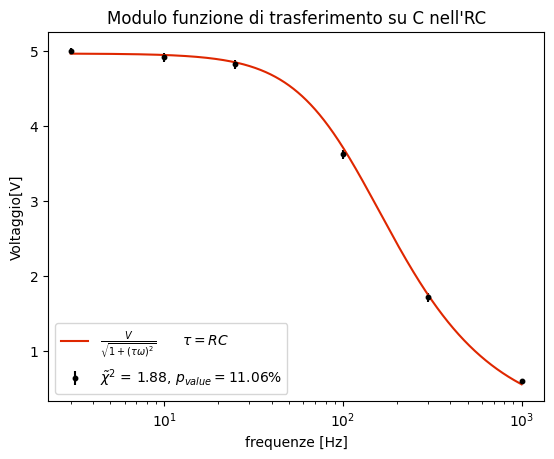

In [ ]:
#@title Graph
a = RCmC
x = x2
y = y2
sy = sy2
txt = 'RLCmC.pdf'
f = Mod_C_RC

def Mod_C_RC( w , t , V ):
  return V/(np.sqrt(1+np.power(t*2*np.pi*w , 2)))

def Arg_C_RC( w , t):
  return - np.arctan(2*np.pi*w*t)
func = r'$\frac{V}{\sqrt{1+(\tau \omega)^{2}}}$      $\tau = RC$'
plt.xlabel( 'frequenze [Hz]')
plt.ylabel( 'Voltaggio[V]')
plt.title('Modulo funzione di trasferimento su C nell\'RC')

plt.xscale('log')


chi = 1-chi2.cdf(a.fval, df= a.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(a.fval/a.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.errorbar( x , y , sy , fmt='o' , markersize=3.2 , color='#000000', label = chi_string)
plt.plot( np.linspace( min(x) , max(x), 10000) ,f( np.linspace( min(x) , max(x), 10000) , a.values[0] , a.values[1]), color = '#DF2700' , label = func)
plt.legend()


plt.savefig(txt)
plt.show()
#files.download(txt)

In [ ]:
#@title analisi dati
n=3
x4 = np.array(data[n][data[n].columns[0]])
y4 = np.array(data[n][data[n].columns[1]])
sy4 = np.array(data[n][data[n].columns[2]])

y4 = (y4-180)*(np.pi)/180
sy4 = sy4 * (np.pi)/180


arg_C = LeastSquares(x4,y4,sy4 , Arg_C_RC)
RCaC = Minuit( arg_C , t = 15e3 *1e-7 )

RCaC.migrad()
RCaC.hesse()

display(RCaC)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.527 (χ²/ndof = 0.5)      │              Nfcn = 23               │
│ EDM = 6.14e-10 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ t    │  1.42e-3  │  0.04e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────┐
│   │       t │
├───┼─────────┤
│ t │ 1.9e-09 │
└───┴─────────┘

In [ ]:
#@title Values



t = RCaC.values[0]

C4 = t/R1
errC4 = propagazione_errore( ['t' , 'R'] , 't/R' , [t,R1] , [[RCaC.errors[0]**2 , 0],[ 0 , .1]])

print(' C = \t' , format(C4 , '.3e') , '+-' , format(errC4, '.3e'))

<IPython.core.display.Latex object>

 C = 	 9.461e-08 +- 2.905e-9


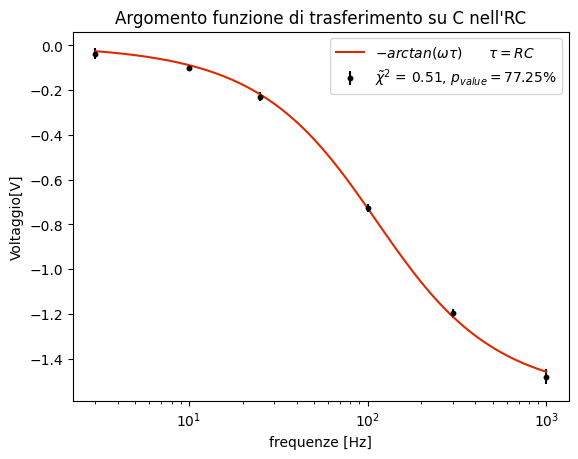

In [ ]:
#@title Graph
a = RCaC
x = x4
y = y4
sy = sy4
txt = 'RCaC.pdf'
f = Arg_C_RC



func = r'$-arctan( \omega \tau)$      $\tau = RC$'
plt.xlabel( 'frequenze [Hz]')
plt.ylabel( 'Voltaggio[V]')
plt.title('Argomento funzione di trasferimento su C nell\'RC')

plt.xscale('log')


chi = 1-chi2.cdf(a.fval, df= a.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(a.fval/a.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.errorbar( x , y , sy , fmt='o' , markersize=3.2 , color='#000000', label = chi_string)
plt.plot( np.linspace( min(x) , max(x), 10000) ,f( np.linspace( min(x) , max(x), 10000) , a.values[0] ), color = '#DF2700' , label = func)
plt.legend()


plt.savefig(txt)
plt.show()
#files.download(txt)

# -------------------------------- RC Final Values ------------------------------------

In [ ]:
#@title Values

a = [C1,C2,C3,C4]
erra = [errC1, errC2 , errC3 , errC4]

C = 0
errC = 0

for i in range(len(a)):
  C +=a[i]/(erra[i]**2)
  errC += 1/(erra[i]**2)

C = C/errC
errC = 1/np.sqrt(np.float32(errC))
print(' C = \t' , format(C , '.3e') , '+-' , format(errC, '.3e'))

 C = 	 9.651e-8 +- 7.284e-10


# Circuito RL

## Voltaggio Resistenza

In [ ]:
#@title analisi dati
n=4
x5 = np.array(data[n][data[n].columns[0]])
y5 = np.array(data[n][data[n].columns[1]])
sy5 = np.array(data[n][data[n].columns[2]])



sy5[3] = .01

modL_R = LeastSquares( x5, y5 , sy5 , Mod_R_RL)
RLmR = Minuit( modL_R , V = 4 , t = 0.05/1e3)


RLmR.migrad()
RLmR.hesse()

#display(RLmR)
a = 0

In [ ]:
#@title Values


t = RLmR.values[0]

L1 = t*R2
errL1 = propagazione_errore( ['t' , 'R'] , 't*R' , [t,R1] , [[RLmR.errors[0]**2 , 0],[ 0 , .1]])

print(' L = \t' , format(L1 , '.3e') , '+-' , format(errL1, '.3e'))

<IPython.core.display.Latex object>

 L = 	 8.104e-02 +- 6.890e-3


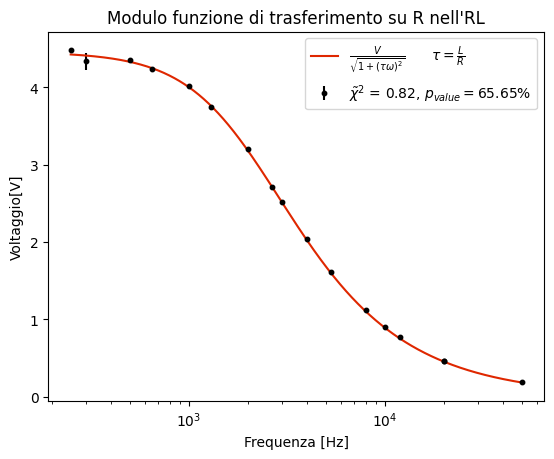

In [ ]:
#@title Graph
a = RLmR
x = x5
y = y5
sy = sy5
txt = 'RLmR.pdf'
f = Mod_R_RL


func = r'$\frac{V}{\sqrt{1+(\tau \omega)^{2}}}$      $\tau = \frac{L}{R}$'
plt.xlabel( 'Frequenza [Hz]')
plt.ylabel( 'Voltaggio[V]')
plt.title('Modulo funzione di trasferimento su R nell\'RL')

plt.xscale('log')


chi = 1-chi2.cdf(a.fval, df= a.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(a.fval/a.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.errorbar( x , y , sy , fmt='o' , markersize=3.2 , color='#000000', label = chi_string)
plt.plot( np.linspace( min(x) , max(x), 10000) ,f( np.linspace( min(x) , max(x), 10000) , a.values[0] , a.values[1]), color = '#DF2700' , label = func)
plt.legend()


plt.savefig(txt)
plt.show()
#files.download(txt)

In [ ]:
#@title analisi dati
n=6
x7 = np.array(data[n][data[n].columns[0]])
y7 = np.array(data[n][data[n].columns[1]])
sy7 = np.array(data[n][data[n].columns[2]])



y7 = y7*np.pi/180
sy7 = sy7*np.pi/180



argL_R = LeastSquares(x7,y7,sy7 , Arg_R_RL)
RLaR = Minuit( argL_R , t =81.8e-6)


RLaR.migrad()
RLaR.hesse()

display(RLaR)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 76.82 (χ²/ndof = 4.8)      │              Nfcn = 18               │
│ EDM = 7.88e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ t    │  82.0e-6  │  0.4e-6   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        t │
├───┼──────────┤
│ t │ 1.42e-13 │
└───┴──────────┘

In [ ]:
#@title Values


t = RLaR.values[0]

L2 = t*R2
errL2 = propagazione_errore( ['t' , 'R'] , 't*R' , [t,R1] , [[RLaR.errors[0]**2 , 0],[ 0 , 1]])

print(' L = \t' , format(L2 , '.3e') , '+-' , format(errL2, '.3e'))

<IPython.core.display.Latex object>

 L = 	 8.531e-02 +- 5.657e-3


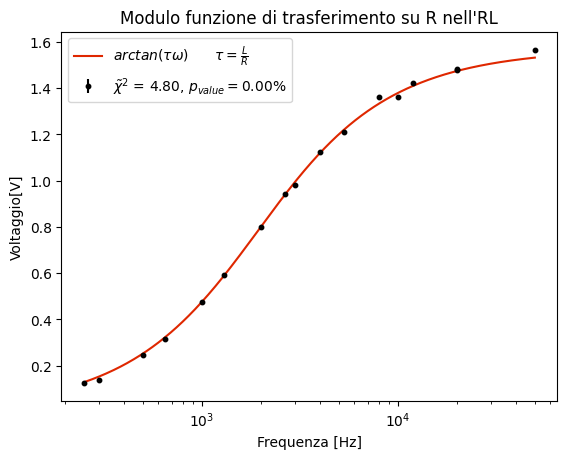

In [ ]:
#@title Graph
a = RLaR
x = x7
y = y7
sy = sy7
txt = 'RLaR.pdf'
f = Arg_R_RL

func = r'$arctan( \tau \omega)$      $\tau = \frac{L}{R}$'
plt.xlabel( 'Frequenza [Hz]')
plt.ylabel( 'Voltaggio[V]')
plt.title('Modulo funzione di trasferimento su R nell\'RL')

plt.xscale('log')


chi = 1-chi2.cdf(a.fval, df= a.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(a.fval/a.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.errorbar( x , y , sy , fmt='o' , markersize=3.2 , color='#000000', label = chi_string)
plt.plot( np.linspace( min(x) , max(x), 10000) ,f( np.linspace( min(x) , max(x), 10000) , a.values[0]), color = '#DF2700' , label = func)
plt.legend()


plt.savefig(txt)
plt.show()
#files.download(txt)


## Voltaggio Induttanza

In [ ]:
#@title analisi dati
n=5
x6 = np.array(data[n][data[n].columns[0]])
y6 = np.array(data[n][data[n].columns[1]])
sy6 = np.array(data[n][data[n].columns[2]])



sy6[-1] = sy6[-3]

for i in range( len( y6 )):
  if y6[i]>5: y6[i] =5

modL_L = LeastSquares(x6,y6,sy6 , Mod_L_RL)
RLmL = Minuit( modL_L , V=5 ,t=8e-6)

#RLmL.fixed['R'] = True

RLmL.migrad()
RLmL.hesse()

display(RLmL)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 16.54 (χ²/ndof = 1.1)      │              Nfcn = 82               │
│ EDM = 1.93e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ t    │  81.1e-6  │  1.1e-6   │            │            │         │         │       │
│ 1 │ V    │   4.978   │   0.029   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────┐
│   │           t           V │
├───┼─────────────────────────┤
│ t │    1.18e-12 -20.8551e-9 │
│ V │ -20.8551e-9    0.000865 │
└───┴─────────────────────────┘

In [ ]:
#@title Values

t = RLmL.values[0]

L3 = t*R2
errL3 = propagazione_errore( ['t' , 'R'] , 't*R' , [t,R1] , [[RLmL.errors[0]**2 , 0],[ 0 , .1]])

print(' L = \t' , format(L2 , '.3e') , '+-' , format(errL2, '.3e'))

<IPython.core.display.Latex object>

 L = 	 8.531e-02 +- 5.657e-3


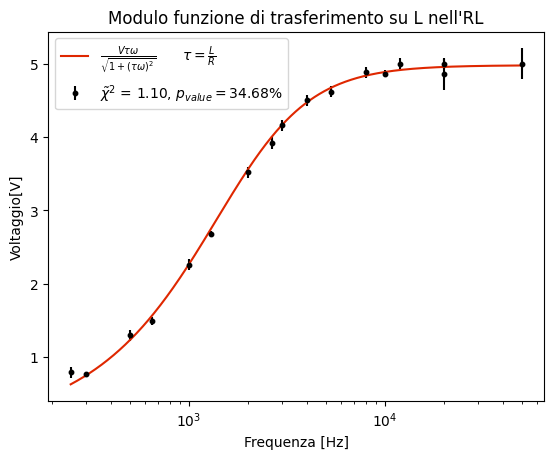

In [ ]:
#@title Graph
a = RLmL
x = x6
y = y6
sy = sy6
txt = 'RLmL.pdf'
f = Mod_L_RL


func = r'$\frac{V \tau \omega}{\sqrt{1+(\tau \omega)^{2}}}$      $\tau = \frac{L}{R}$'
plt.xlabel( 'Frequenza [Hz]')
plt.ylabel( 'Voltaggio[V]')
plt.title('Modulo funzione di trasferimento su L nell\'RL')

plt.xscale('log')


chi = 1-chi2.cdf(a.fval, df= a.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(a.fval/a.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.errorbar( x , y , sy , fmt='o' , markersize=3.2 , color='#000000', label = chi_string)
plt.plot( np.linspace( min(x) , max(x), 10000) ,f( np.linspace( min(x) , max(x), 10000) , a.values[0], a.values[1]), color = '#DF2700' , label = func)
plt.legend()


plt.savefig(txt)
plt.show()
#files.download(txt)

In [ ]:
#@title analisi dati
n=7
x8 = np.array(data[n][data[n].columns[0]])
y8 = np.array(data[n][data[n].columns[1]])
sy8 = np.array(data[n][data[n].columns[2]])



x8= x8[2::]
y8= y8[2::]
sy8= sy8[2::]


for i in range(len(y8)):
  if y8[i]>72:
    y8[i] = 180-y8[i]



y8 = y8*np.pi/180
sy8 = sy8*np.pi/180
sy8 = 0.03*np.ones(len(y8))

argL_L = LeastSquares(x8,y8,sy8 , Arg_L_RL)
RLaL = Minuit( argL_L , t =0.05/1e3)


RLaL.migrad()
RLaL.hesse()

display(RLaL)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 17.91 (χ²/ndof = 1.3)      │              Nfcn = 31               │
│ EDM = 6.9e-07 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ t    │  94.8e-6  │  2.3e-6   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        t │
├───┼──────────┤
│ t │ 5.47e-12 │
└───┴──────────┘

In [ ]:
#@title Values

t = RLaL.values[0]

L4 = t*R2
errL4 = propagazione_errore( ['t' , 'R'] , 't*R' , [t,R1] , [[RLaL.errors[0]**2 , 0],[ 0 , .1]])

print(' L = \t' , format(L4 , '.3e') , '+-' , format(errL4, '.3e'))

<IPython.core.display.Latex object>

 L = 	 9.858e-02 +- 3.507e-2


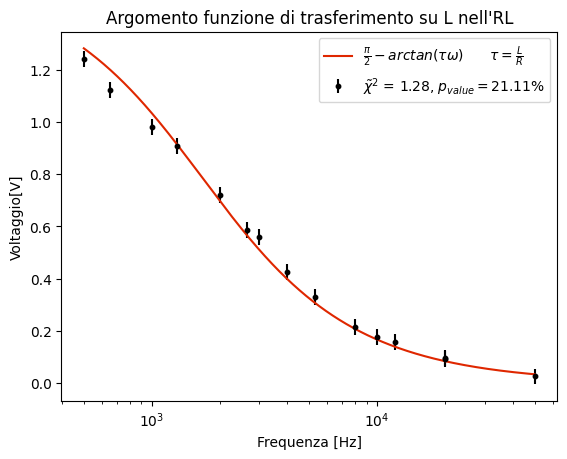

In [ ]:
#@title Graph
a = RLaL
x = x8
y = y8
sy = sy8
txt = 'RLaL.pdf'
f = Arg_L_RL


func = r'$\frac{\pi}{2} - arctan(\tau \omega)$      $\tau = \frac{L}{R}$'
plt.xlabel( 'Frequenza [Hz]')
plt.ylabel( 'Voltaggio[V]')
plt.title('Argomento funzione di trasferimento su L nell\'RL')

plt.xscale('log')


chi = 1-chi2.cdf(a.fval, df= a.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(a.fval/a.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.errorbar( x , y , sy , fmt='o' , markersize=3.2 , color='#000000', label = chi_string)
plt.plot( np.linspace( min(x) , max(x), 10000) ,f( np.linspace( min(x) , max(x), 10000) , a.values[0]), color = '#DF2700' , label = func)
plt.legend()


plt.savefig(txt)
plt.show()
#files.download(txt)


# -------------------------------- RL Final Values ------------------------------------

In [ ]:
#@title Values

a = [L1,L2,L3,L4]
erra = [errL1, errL2 , errL3 , errL4]

L = 0
errL = 0

for i in range(len(a)):
  L +=a[i]/(erra[i]**2)
  errL += 1/(erra[i]**2)

L = L/errL
errL = 1/np.sqrt(np.float32(errL))
print(' L = \t' , format(L , '.3e') , '+-' , format(errL, '.3e'))

 L = 	 8.386e-2 +- 4.192e-03


# Circuito RLC

## Circuito LCR

In [ ]:
#@title analisi dati
n=8
x9 = np.array(data[n][data[n].columns[0]])
y9 = np.array(data[n][data[n].columns[1]])
sy9 = np.array(data[n][data[n].columns[2]])


modLC_R = LeastSquares(x9,y9,sy9 , Mod_R_RLC)
RLCmR = Minuit( modLC_R , V = 5 , g = 1e-4 , t = 8e-9)

#RLCmR.fixed['V'] = True

RLCmR.migrad()
RLCmR.hesse()

display(RLCmR)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.311 (χ²/ndof = 0.9)      │              Nfcn = 102              │
│ EDM = 5.04e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ g    │ 110.5e-6  │  1.0e-6   │            │            │         │         │       │
│ 1 │ t    │  8.40e-9  │  0.04e-9  │            │            │         │         │       │
│ 2 │ V    │   4.407   │   0.026   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────────────────────────────┐
│   │                g                t                V │
├───┼────────────────────────────────────────────────────┤
│ g │         1.02e-12      24.4187e-18      -22.1049e-9 │
│ t │      24.4187e-18         1.86e-21 -118.9401817e-15 │
│ V │      -22.1049e-9 -118.9401817e-15         0.000691 │
└───┴────────────────────────────────────────────────────┘

In [ ]:
#@title Values
# g = RC
# t = LC

a = RLCmR
g = a.values[0]
t = a.values[1]
errg = a.errors[0]
errt = a.errors[1]

C1 = g/R3
errC1 = propagazione_errore( ['g' , 'R'] , 'g/R' , [g,R3] , [[errg**2 , 0],[ 0 , .1]])

L1 = t/C1
errL1 = propagazione_errore( ['t' , 'C'] , 't/C' , [t,C1] , [[errt**2 , 0],[ 0 , errC1**2]])


print(' C = \t' , format(C1 , '.3e') , '+-' , format(errC1, '.3e'))
print(' L = \t' , format(L1 , '.3e') , '+-' , format(errL1, '.3e'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

 C = 	 1.062e-07 +- 9.723e-10
 L = 	 7.909e-02 +- 8.301e-4


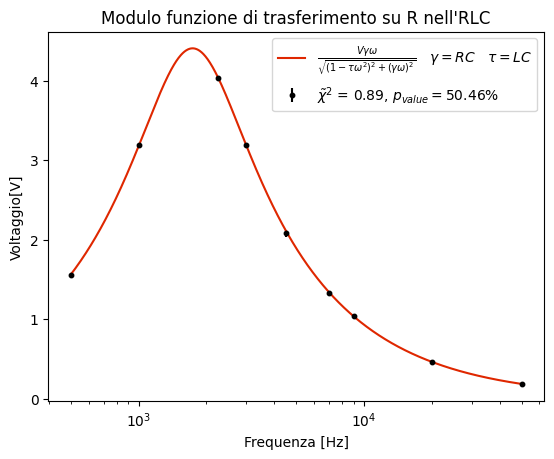

In [ ]:
#@title Graph
a = RLCmR
x = x9
y = y9
sy = sy9
txt = 'RLCmR.pdf'
f = Mod_R_RLC


func = r'$\frac{V \gamma \omega}{\sqrt{(1 - \tau\omega^{2})^{2} + (\gamma \omega)^{2}}}$   $\gamma = RC$   $\tau = LC$'
plt.xlabel( 'Frequenza [Hz]')
plt.ylabel( 'Voltaggio[V]')
plt.title('Modulo funzione di trasferimento su R nell\'RLC')

plt.xscale('log')


chi = 1-chi2.cdf(a.fval, df= a.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(a.fval/a.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.errorbar( x , y , sy , fmt='o' , markersize=3.2 , color='#000000', label = chi_string)
plt.plot( np.linspace( min(x) , max(x), 10000) ,f( np.linspace( min(x) , max(x), 10000) , a.values[0],a.values[1],a.values[2]), color = '#DF2700' , label = func)
plt.legend()


plt.savefig(txt)
plt.show()
#files.download(txt)


In [ ]:
#@title analisi dati
n=9
x10 = np.array(data[n][data[n].columns[0]])
y10 = np.array(data[n][data[n].columns[1]])
sy10 = np.array(data[n][data[n].columns[2]])*2

# print(y10)
y10[0] = -y10[0]
y10[1] = -y10[1]
#y10 = y10 + 90
y10=y10*np.pi/180
sy10=sy10*np.pi/180

print(sy10/y10)
#sy10 = 0.01 * np.ones(len(sy10))


ArgLC_R = LeastSquares(x10,y10,sy10 , Arg_R_RLC)
RLCaR = Minuit( ArgLC_R , C = 1e-7 , L = 0.05)

#RLCaR.fixed['C'] = True
RLCaR.limits['C' , 'L'] = (0,None)

RLCaR.migrad()
RLCaR.hesse()

display(RLCaR)

[-0.01083209 -0.01175138  0.0416323   0.02730807  0.00937447  0.01492917
  0.01028811  0.01048569  0.00887652]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 16.51 (χ²/ndof = 2.4)      │              Nfcn = 71               │
│ EDM = 2.19e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ L    │   0.516   │   0.007   │            │            │    0    │         │       │
│ 1 │ C    │  649e-9   │   9e-9    │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────┐
│   │             L             C │
├───┼─────────────────────────────┤
│ L │      5.62e-05 -38.42729e-12 │
│ C │ -38.42729e-12      7.72e-17 │
└───┴─────────────────────────────┘

In [ ]:
#@title Values
# g = RC
# t = LC
a = RLCaR

L2 = a.values[0]
errL2 = a.errors[0]

C2 = a.values[1]
errC2 = a.errors[1]
print('L = \t' ,format(a.values[0] , '.3e') , '+-' , format(a.errors[0], '.3e'))
print('C = \t' ,format(a.values[1] , '.3e') , '+-' , format(a.errors[1], '.3e'))

L = 	 5.160e-01 +- 7.494e-03
C = 	 6.494e-07 +- 8.789e-09


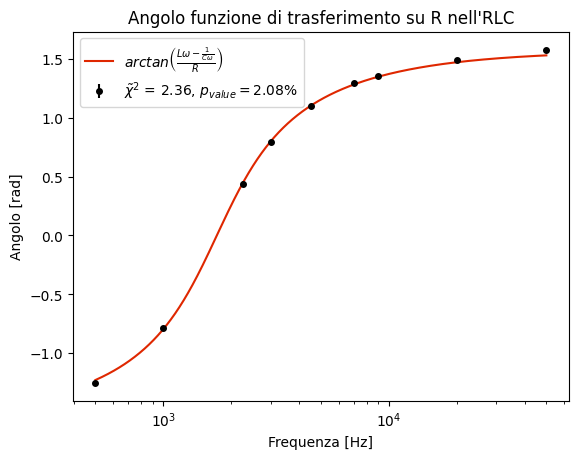

In [ ]:
#@title Graph
a = RLCaR
x = x10
y = y10
sy = sy10
txt = 'RLCaR.pdf'
f = Arg_R_RLC



func = r'$ arctan\left( \frac{L\omega - \frac{1}{C\omega}}{R}\right)$'
plt.xlabel( 'Frequenza [Hz]')
plt.ylabel( 'Angolo [rad]')
plt.title('Angolo funzione di trasferimento su R nell\'RLC')

plt.xscale('log')


chi = 1-chi2.cdf(a.fval, df= a.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(a.fval/a.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.errorbar( x , y , sy , fmt='o' , markersize=4 , color='#000000', label = chi_string)
plt.plot( np.linspace( min(x) , max(x), 10000) ,f( np.linspace( min(x) , max(x), 10000) , a.values[0],a.values[1]), color = '#DF2700' , label = func)
plt.legend()


plt.savefig(txt)
plt.show()
#files.download(txt)

##Circuito RLC

In [ ]:
#@title analisi dati
n=10
x11 = np.array(data[n][data[n].columns[0]])
y11 = np.array(data[n][data[n].columns[1]])
sy11 = np.array(data[n][data[n].columns[2]])


sy11 = 0.01*np.ones(len(x11))

for i in range( len( y11 )):
  if y11[i]>5: y11[i] =5


modLC_C = LeastSquares(x11,y11,sy11 , Mod_C_RLC)
RLCmC = Minuit( modLC_C , V = 5 , g = 108.3e-6 , t = 8.47e-9)

RLCmC.limits['V', 'g' , 't'] = (0,None)
#RLCmC.fixed['V'] = True

RLCmC.migrad()
RLCmC.hesse()

display(RLCmC)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 23.6 (χ²/ndof = 5.9)       │              Nfcn = 84               │
│ EDM = 1.93e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ g    │ 112.4e-6  │  0.4e-6   │            │            │    0    │         │       │
│ 1 │ t    │  7.86e-9  │  0.05e-9  │            │            │    0    │         │       │
│ 2 │ V    │   4.943   │   0.008   │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────────────────────────────┐
│   │                g                t                V │
├───┼────────────────────────────────────────────────────┤
│ g │            2e-13      -4.5381e-18       2.73479e-9 │
│ t │      -4.5381e-18         2.74e-21 -155.3988291e-15 │
│ V │       2.73479e-9 -155.3988291e-15         6.98e-05 │
└───┴────────────────────────────────────────────────────┘

In [ ]:
#@title Values
# g = RC
# t = LC

a = RLCmC
g = a.values[0]
t = a.values[1]
errg = a.errors[0]
errt = a.errors[1]

C3 = g/R3
errC3 = propagazione_errore( ['g' , 'R'] , 'g/R' , [g,R3] , [[errg**2 , 0],[ 0 , .1]])

L3 = t/C3
errL3 = propagazione_errore( ['t' , 'C'] , 't/C' , [t,C3] , [[errt**2 , 0],[ 0 , errC3**2]])


print(' C = \t' , format(C3 , '.3e') , '+-' , format(errC3, '.3e'))
print(' L = \t' , format(L3 , '.3e') , '+-' , format(errL3, '.3e'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

 C = 	 1.081e-07 +- 4.314e-10
 L = 	 7.269e-02 +- 5.647e-4


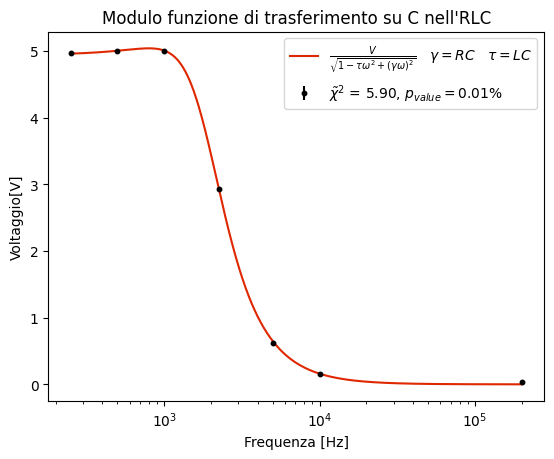

In [ ]:
#@title Graph
a = RLCmC
x = x11
y = y11
sy = sy11
txt = 'RLCmC.pdf'
f = Mod_C_RLC




func = r'$\frac{V}{\sqrt{1 - \tau\omega^{2} + (\gamma \omega)^{2}}}$   $\gamma = RC$   $\tau = LC$'
plt.xlabel( 'Frequenza [Hz]')
plt.ylabel( 'Voltaggio[V]')
plt.title('Modulo funzione di trasferimento su C nell\'RLC')

plt.xscale('log')


chi = 1-chi2.cdf(a.fval, df= a.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(a.fval/a.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.errorbar( x , y , sy , fmt='o' , markersize=3.2 , color='#000000', label = chi_string)
plt.plot( np.linspace( min(x) , max(x), 10000) ,f( np.linspace( min(x) , max(x), 10000) , a.values[0],a.values[1],a.values[2]), color = '#DF2700' , label = func)
plt.legend()


plt.savefig(txt)
plt.show()
#files.download(txt)

In [ ]:
#@title analisi dati
n=11
x12 = np.array(data[n][data[n].columns[0]])
y12 = np.array(data[n][data[n].columns[1]])
sy12 = np.array(data[n][data[n].columns[2]])



y12=-y12*np.pi/180
sy12=sy12*np.pi/180
sy12[-1] = sy12[0]
#sy12 = 0.01*np.ones(len(y12))
y12[-1] = -np.pi


argLC_C = LeastSquares(x12,y12,sy12 , Arg_C_RLC)
RLCaC = Minuit( argLC_C , L=0.05, C=1e-7)

#RLCaC.fixed['C'] = True


RLCaC.migrad()
RLCaC.hesse()


display(RLCaC)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 109.8 (χ²/ndof = 22.0)     │              Nfcn = 71               │
│ EDM = 8.38e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ L    │   0.504   │   0.004   │            │            │         │         │       │
│ 1 │ C    │  653e-9   │   5e-9    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────────┐
│   │              L              C │
├───┼───────────────────────────────┤
│ L │       1.76e-05 -11.772841e-12 │
│ C │ -11.772841e-12       2.14e-17 │
└───┴───────────────────────────────┘

In [ ]:
#@title Values
# g = RC
# t = LC
a = RLCaC

L4 = a.values[0]
errL4 = a.errors[0]

C4 = a.values[1]
errC4 = a.errors[1]
print('L = \t' ,format(a.values[0] , '.3e') , '+-' , format(a.errors[0], '.3e'))
print('C = \t' ,format(a.values[1] , '.3e') , '+-' , format(a.errors[1], '.3e'))

L = 	 5.040e-01 +- 4.190e-03
C = 	 6.527e-07 +- 4.621e-09


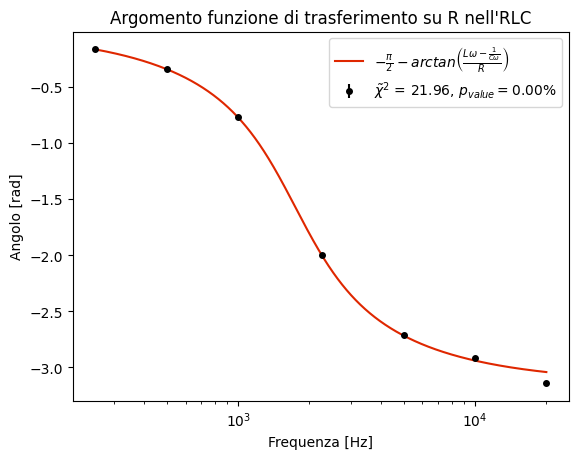

In [ ]:
#@title Graph
a = RLCaC
x = x12
y = y12
sy = sy12
txt = 'RLCaC.pdf'
f = Arg_C_RLC



func = r'$ -\frac{\pi}{2} - arctan\left(  \frac{L\omega - \frac{1}{C\omega}}{R} \right)$'
plt.xlabel( 'Frequenza [Hz]')
plt.ylabel( 'Angolo [rad]')
plt.title('Argomento funzione di trasferimento su R nell\'RLC')

plt.xscale('log')


chi = 1-chi2.cdf(a.fval, df= a.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(a.fval/a.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.errorbar( x , y , sy , fmt='o' , markersize=4 , color='#000000', label = chi_string)
plt.plot( np.linspace( min(x) , max(x), 10000) ,f( np.linspace( min(x) , max(x), 10000) , a.values[0],a.values[1]), color = '#DF2700' , label = func)
plt.legend()


plt.savefig(txt)
plt.show()
#files.download(txt)

##Circuito CRL

In [ ]:
#@title analisi dati
n=12
x13 = np.array(data[n][data[n].columns[0]])
y13 = np.array(data[n][data[n].columns[1]])
sy13 = np.array(data[n][data[n].columns[2]])



modLC_L = LeastSquares(x13,y13,sy13 , Mod_L_RLC)
RLCmL = Minuit( modLC_L , V = 5 , g = 110.5e-6, t = 8.64e-9)

#RLCmL.fixed['V'] = True

RLCmL.migrad()
RLCmL.hesse()

display(RLCmL)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 16.81 (χ²/ndof = 4.2)      │              Nfcn = 76               │
│ EDM = 6.37e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ g    │ 110.5e-6  │  1.1e-6   │            │            │         │         │       │
│ 1 │ t    │  8.64e-9  │  0.05e-9  │            │            │         │         │       │
│ 2 │ V    │   4.953   │   0.018   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────────────────────────────┐
│   │                g                t                V │
├───┼────────────────────────────────────────────────────┤
│ g │         1.17e-12      15.7774e-18        6.9205e-9 │
│ t │      15.7774e-18         2.33e-21 -418.9817845e-15 │
│ V │        6.9205e-9 -418.9817845e-15         0.000323 │
└───┴────────────────────────────────────────────────────┘

In [ ]:
#@title Values
# g = RC
# t = LC

a = RLCmL
g = a.values[0]
t = a.values[1]
errg = a.errors[0]
errt = a.errors[1]

C5 = g/R3
errC5 = propagazione_errore( ['g' , 'R'] , 'g/R' , [g,R3] , [[errg**2 , 0],[ 0 , .1]])

L5 = t/C5
errL5 = propagazione_errore( ['t' , 'C'] , 't/C' , [t,C5] , [[errt**2 , 0],[ 0 , errC5**2]])


print(' C = \t' , format(C5 , '.3e') , '+-' , format(errC5, '.3e'))
print(' L = \t' , format(L5 , '.3e') , '+-' , format(errL5, '.3e'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

 C = 	 1.062e-07 +- 1.040e-9
 L = 	 8.133e-02 +- 9.163e-4


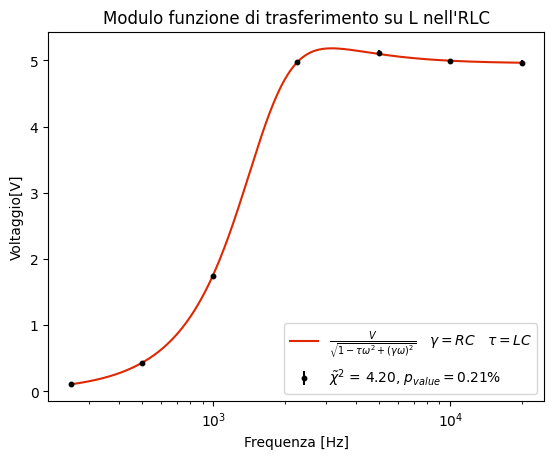

In [ ]:
#@title Graph
a = RLCmL
x = x13
y = y13
sy = sy13
txt = 'RLCmL.pdf'
f = Mod_L_RLC




func = r'$\frac{V}{\sqrt{1 - \tau\omega^{2} + (\gamma \omega)^{2}}}$   $\gamma = RC$   $\tau = LC$'
plt.xlabel( 'Frequenza [Hz]')
plt.ylabel( 'Voltaggio[V]')
plt.title('Modulo funzione di trasferimento su L nell\'RLC')

plt.xscale('log')


chi = 1-chi2.cdf(a.fval, df= a.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(a.fval/a.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.errorbar( x , y , sy , fmt='o' , markersize=3.2 , color='#000000', label = chi_string)
plt.plot( np.linspace( min(x) , max(x), 10000) ,f( np.linspace( min(x) , max(x), 10000) , a.values[0],a.values[1],a.values[2]), color = '#DF2700' , label = func)
plt.legend()


plt.savefig(txt)
plt.show()
#files.download(txt)

In [ ]:
#@title analisi dati
n=13
x14 = np.array(data[n][data[n].columns[0]])
y14 = np.array(data[n][data[n].columns[1]])
sy14 = np.array(data[n][data[n].columns[2]])

sy14[3] = sy14[2]


y14=y14*np.pi/180
sy14=sy14*np.pi/18




argLC_L = LeastSquares(x14,y14,sy14 , Arg_L_RLC)
RLCaL = Minuit( argLC_L , L=0.005, C=1e-7)

RLCaL.fixed['C','L'] = (0,1)
#RLCaL.fixed['C'] = True
RLCaL.fixed['L'] = False
RLCaL.migrad()
RLCaL.hesse()

display(RLCaL)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 20.75 (χ²/ndof = 4.2)      │              Nfcn = 110              │
│ EDM = 1.62e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ L    │   0.51    │   0.06    │            │            │         │         │       │
│ 1 │ C    │  0.93e-6  │  0.10e-6  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────┐
│   │            L            C │
├───┼───────────────────────────┤
│ L │      0.00314 -3.551819e-9 │
│ C │ -3.551819e-9     9.39e-15 │
└───┴───────────────────────────┘

In [ ]:
#@title Values
# g = RC
# t = LC
a = RLCaL

L6 = a.values[0]
errL6 = a.errors[0]

C6 = a.values[1]
errC6 = a.errors[1]
print('L = \t' ,format(a.values[0] , '.3e') , '+-' , format(a.errors[0], '.3e'))
print('C = \t' ,format(a.values[1] , '.3e') , '+-' , format(a.errors[1], '.3e'))

L = 	 5.139e-01 +- 5.607e-02
C = 	 9.264e-07 +- 9.691e-08


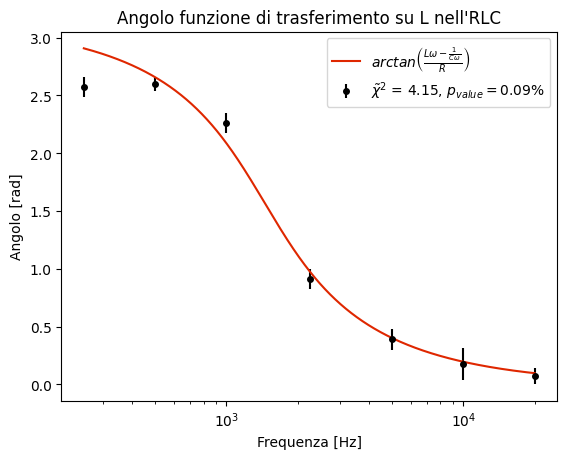

In [ ]:
#@title Graph
a = RLCaL
x = x14
y = y14
sy = sy14
txt = 'RLCaL.pdf'
f = Arg_L_RLC



func = r'$ arctan\left( \frac{L\omega - \frac{1}{C\omega}}{R}\right)$'
plt.xlabel( 'Frequenza [Hz]')
plt.ylabel( 'Angolo [rad]')
plt.title('Angolo funzione di trasferimento su L nell\'RLC')

plt.xscale('log')


chi = 1-chi2.cdf(a.fval, df= a.ndof)
chi_string = r'$\tilde{\chi}^2$ = ' + f'{(a.fval/a.ndof):.2f}'+r', $p_{value}=$' + f'{(chi*100):.2f}' + '$\%$'
plt.errorbar( x , y , sy , fmt='o' , markersize=4 , color='#000000', label = chi_string)
plt.plot( np.linspace( min(x) , max(x), 10000) ,f( np.linspace( min(x) , max(x), 10000) , a.values[0],a.values[1]), color = '#DF2700' , label = func)
plt.legend()


plt.savefig(txt)
plt.show()
#files.download(txt)

# -------------------------------- RLC Final Values ------------------------------------

In [ ]:
#@title Values

#a = [C,C1,C2,C3,C4,C5,C6]
#erra = [errC,errC1, errC2 , errC3 , errC4 , errC5 , errC6]

a = np.array([C1,C2,C3,C4,C5,C6])
erra = np.array([errC1, errC2 , errC3 , errC4 , errC5 , errC6])

#b = [L,L1,L2,L3,L4,L5,L6]
#errb = [errL,errL1, errL2 , errL3 , errL4 , errL5 , errL6]

b = np.array([L1,L2,L3,L4,L5,L6])
errb = np.array([errL1, errL2 , errL3 , errL4 , errL5 , errL6])

Cf = 0
errCf = 0

for i in range(len(a)):
  Cf +=a[i]/(erra[i]**2)
  errCf += 1/(erra[i]**2)

Cf = Cf/errCf
errCf = 1/np.sqrt(np.float32(errCf))


Lf = 0
errLf = 0

for i in range(len(b)):
  Lf +=b[i]/(errb[i]**2)
  errLf += 1/(errb[i]**2)

Lf = Lf/errLf
errLf = 1/np.sqrt(np.float32(errLf))


print(' C = \t' , format(Cf , '.3e') , '+-' , format(errCf, '.3e'))
print(' L = \t' , format(Lf, '.3e') , '+-' , format(errLf, '.3e'))

 C = 	 1.120e-7 +- 3.672e-10
 L = 	 8.161e-2 +- 4.133e-04


# Distanza dal valore vero

In [ ]:
nC = abs(Ct-C)/errC
nL = abs(Lt-L)/errL

nCf = abs(C - Cf)/errCf
nLf = abs(L - Lf)/errLf

print( nC,nL,nCf,nLf)

4.79239812927386 0.919596828228864 42.0966844012661 5.43898175460438


# Distribuzione

-0.009 0.764 0.023 0.018


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 63.7 (χ²/ndof = 3.5)       │              Nfcn = 36               │
│ EDM = 1.23e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n    │   -0.01   │   0.05    │            │            │         │         │       │
│ 1 │ s    │   0.760   │   0.032   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       n       s │
├───┼─────────────────┤
│ n │ 0.00202   0.000 │
│ s │   0.000 0.00102 │
└───┴─────────────────┘

5.087515591029046e-07 18.0


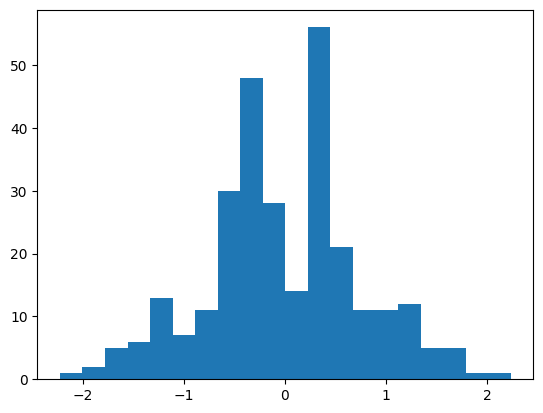

In [ ]:
def cdf( x , n , s):
  return norm.cdf(x,loc=n , scale=s )


k = 2.44
n=14
w = np.array(data[n][data[n].columns[0]])
A1 = np.array(data[n][data[n].columns[1]])
dp1 = np.array(data[n][data[n].columns[2]])
A2 = np.array(data[n][data[n].columns[3]])
dp2 = np.array(data[n][data[n].columns[4]])



ausyA1 = [A1[0]]
ausydp1 = [dp1[0]]
ausyA2 = [A2[0]]
ausydp2 = [dp2[0]]
net = []

for i in range(1, len(w)):

  if w[i] == w[i-1]:
    ausyA1.append(A1[i])
    ausydp1.append(dp1[i])
    ausyA2.append(A2[i])
    ausydp2.append(dp2[i])
  else:

    avg = [np.mean(ausyA1) , np.mean(ausydp1) , np.mean(ausyA2) , np.mean(ausydp2)]
    std = [np.std(ausyA1) , np.std(ausydp1) , np.std(ausyA2) , np.std(ausydp2)]

    for ii in range(4):
      if std[ii] == 0: std[ii] = 1
    for iii in range( len(ausyA1)):
      net.append( (ausyA1[iii] - avg[0])/(std[0]*k))
      net.append( (ausydp1[iii] - avg[1])/(std[1]))
      net.append( (ausyA2[iii] - avg[2])/(std[2]*k))
      net.append( (ausydp2[iii] - avg[3])/(std[3]))
      continue
    ausyA1 = [A1[i]]
    ausydp1 = [dp1[i]]
    ausyA2 = [A2[i]]
    ausydp2 = [dp2[i]]



net = np.array(net)
net = [ net[i] for i in np.nonzero(net)]
net1 = np.array(net)





count,bin, patches = plt.hist( net1[0] , bins=int(np.ceil( 1 + 3.322 * np.log(len(net1[0])))))

print(round(np.mean(net1[0]),3) , round(np.std(net1[0]),3) , round(skew(net1[0]),3) , round(kurtosis(net1[0]),3))

cost = BinnedNLL(count , bin , cdf)
hist = Minuit( cost , n = np.mean(net1[0]) , s = np.std(net1[0]))
hist.migrad()
hist.hesse()
display(hist)

print( 1 - chi2.cdf(hist.fval , df= hist.ndof) , hist.ndof)

-0.0 0.75 -0.112 0.332


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 128.8 (χ²/ndof = 6.8)      │              Nfcn = 42               │
│ EDM = 5.07e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mean  │  -0.0000  │  0.0017   │            │            │         │         │       │
│ 1 │ sigma │   0.746   │   0.030   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │     mean    sigma │
├───────┼───────────────────┤
│  mean │ 2.84e-06        0 │
│ sigma │        0  0.00092 │
└───────┴───────────────────┘

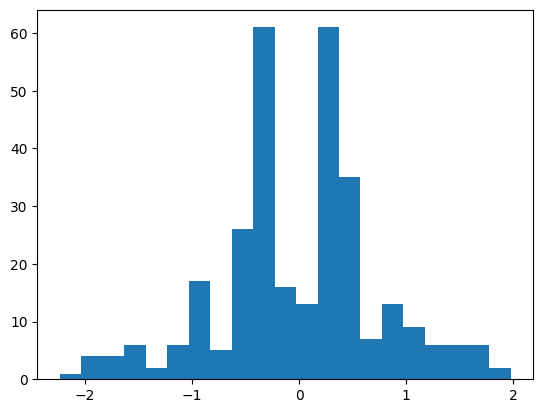

In [ ]:
def nord( x , mean , sigma):
  return norm.cdf( x , loc = mean , scale = sigma)



n=15
w = np.array(data[n][data[n].columns[0]])
A1 = np.array(data[n][data[n].columns[1]])
dp1 = np.array(data[n][data[n].columns[2]])




ausyA1 = [A1[0]]
ausydp1 = [dp1[0]]

net = []

for i in range(1, len(w)):

  if w[i] == w[i-1]:
    ausyA1.append(A1[i])
    ausydp1.append(dp1[i])

  else:

    avg = [np.mean(ausyA1) , np.mean(ausydp1) ]
    std = [np.std(ausyA1) , np.std(ausydp1) ]

    for ii in range(2):
      if std[ii] == 0: std[ii] = 1
    for iii in range( len(ausyA1)):
      net.append( (ausyA1[iii] - avg[0])/(std[0]*3))
      net.append( (ausydp1[iii] - avg[1])/(std[1]))

      continue
    ausyA1 = [A1[i]]
    ausydp1 = [dp1[i]]




net = np.array(net)
net = [ net[i] for i in np.nonzero(net)]
net2 = np.array(net)



count,bin,p = plt.hist( net2[0] , bins=int(np.ceil( 1 + 3.322 * np.log(len(net2[0])))))
print(round(np.mean(net2[0]),3) , round(np.std(net2[0]),3) , round(skew(net2[0]),3) , round(kurtosis(net2[0]),3))

cost = BinnedNLL(count,bin,nord)
u = Minuit( cost , mean=np.mean(net2[0]) , sigma = np.std( net2[0]))
u.migrad()
u.hesse()
display(u)

# Critici

## Resistenze

In [ ]:
#@title 1kOhm

n=8
x9 = np.array(data[n][data[n].columns[0]])
y9 = np.array(data[n][data[n].columns[1]])
sy9 = np.array(data[n][data[n].columns[2]])



modLC_R = LeastSquares(x9,y9,sy9 , Mod_R_RLC)
C1 = Minuit( modLC_R , V=5 ,g = 1e-4 , t = 8e-9)

#RLCmR.fixed['V'] = True

C1.migrad()
C1.hesse()

#display(C1)
sy = np.mean(sy9)

In [ ]:
#@title 100Ohm

n=16
x17 = np.array(data[n][data[n].columns[0]])
y17 = np.array(data[n][data[n].columns[1]])



modLC_R = LeastSquares(x17,y17,sy , Mod_R_RLC)
C2 = Minuit( modLC_R , V = 5 , g = Rc[n-15]*Ct, t = Lt*Ct)

#RLCmR.fixed['V'] = True

C2.migrad()
C2.hesse()

#display(C2)
h = 0

In [ ]:
#@title 500Ohm

n=17
x18 = np.array(data[n][data[n].columns[0]])
y18 = np.array(data[n][data[n].columns[1]])



modLC_R = LeastSquares(x18,y18,sy , Mod_R_RLC)
C3 = Minuit( modLC_R , V=5 , g = Rc[n-15]*Ct, t = Lt*Ct)

#RLCmR.fixed['V'] = True

C3.migrad()
C3.hesse()

#display(C3)
h = 0

In [ ]:
#@title 2.5Khm

n=18
x19 = np.array(data[n][data[n].columns[0]])
y19 = np.array(data[n][data[n].columns[1]])



modLC_R = LeastSquares(x19,y19,sy , Mod_R_RLC)
C4 = Minuit( modLC_R , V=5 , g = Rc[n-15]*Ct, t = Lt*Ct)

#RLCmR.fixed['V'] = True

C4.migrad()
C4.hesse()

h = 0

In [ ]:
#@title 5Khm

n=19
x20 = np.array(data[n][data[n].columns[0]])
y20 = np.array(data[n][data[n].columns[1]])



modLC_R = LeastSquares(x20,y20,sy , Mod_R_RLC)
C5 = Minuit( modLC_R , V=5 , g = Rc[n-15]*Ct, t = Lt*Ct)

#RLCmR.fixed['V'] = True

C5.migrad()
C5.hesse()

#display(C5)
h = 0

In [ ]:
#@title 750hm

n=20
x21 = np.array(data[n][data[n].columns[0]])
y21 = np.array(data[n][data[n].columns[1]])



modLC_R = LeastSquares(x21,y21,sy , Mod_R_RLC)
C6 = Minuit( modLC_R , V=5 , g = Rc[n-15]*Ct, t = Lt*Ct)

#RLCmR.fixed['V'] = True

C6.migrad()
C6.hesse()

#display(C6)
h = 0

## Grafico

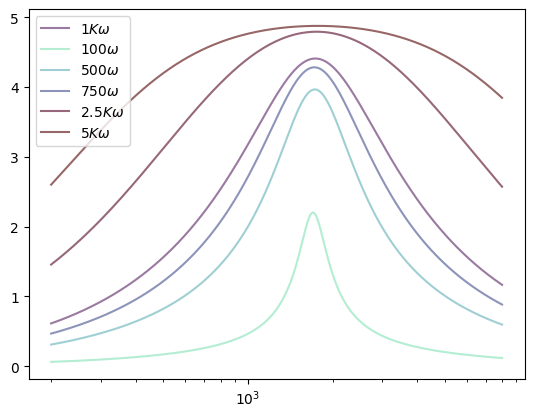

In [ ]:
f = Mod_R_RLC
x = x21
crit = [C1,C2,C3,C4,C5,C6]

lista = ['$1K\omega$' , '$100\omega$' ,'$500\omega$' , '$750\omega$' , '$2.5K\omega$' , '$5K\omega$' ]
colors1 = ['#9A7AA0','#B4EDD2','#A0CFD3','#8D94BA','#97677B','#976767']
colors2 = [ '#7E6C6C' , '#F87575' , '#FFA9A3']
plt.xscale('log')
i = 0
for a in crit:
  plt.plot( np.linspace( min(x) , max(x), 10000) ,f( np.linspace( min(x) , max(x), 10000) , a.values[0],a.values[1],a.values[2]),color = colors1[i], label = lista[i])
  i+=1
plt.legend()
plt.show()

In [ ]:
w = Symbol('w')
g = Symbol('g')
t = Symbol('t')
V = Symbol('V')
display( Latex(latex(simplify(diff( r'(V * g * w)/( sqrt( (1 - (t*w**2))**2 + ( w*g)**2))' , w)))))

In [ ]:
print( Lt*Lt )

In [ ]:
V = []
for i in crit: V.append(i.values[2])
V = np.array(V)


V = sorted(V)
Rc = sorted(Rc)

def Vcrit( R , C , L , V):
  return V*np.sqrt(C)*R/(np.sqrt( np.power(R , 2)*C + L))

ArgLC_R = LeastSquares(Rc, V , .1 , Vcrit)
Vc = Minuit( ArgLC_R , V = 5 , C = 1e-7 , L= 0.05)

Vc.limits['L' , 'C'] = (0,None)

Vc.migrad()
Vc.hesse()

display(Vc)